Sources
- https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
- https://people.duke.edu/~rnau/411arim.htm#mixed
- https://otexts.com/fpp2/stationarity.html
- https://otexts.com/fpp3/seasonal-arima.html
- https://people.duke.edu/~rnau/arimrule.htm


In [88]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load data

In [89]:
data_dir = os.path.join(os.getcwd(), "../ucla-covid19-prediction")
dataset = pd.read_csv(os.path.join(data_dir, "train_trendency.csv"), index_col=0)
test_dataset = pd.read_csv(os.path.join(data_dir, "test_data.csv"), index_col=0)
dataset["Date"] = dataset["Date"].map(lambda date: date[:5])

# Make data stationary
- fitting LOESS smoother with appropriate period
- test out various states to ensure robust period

In [104]:
state = 'Texas'
state_dataset = dataset[dataset["Province_State"] == state]
state_series = state_dataset.set_index('Date')
X = state_series.drop(
    columns=["Recovered", "Active", "Province_State", "Confirmed", "Deaths"])
y = state_series['Confirmed']
z = state_series['Deaths']

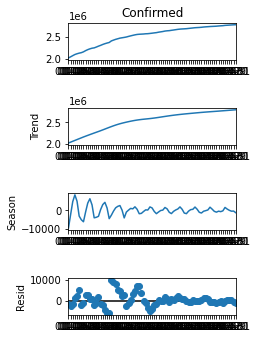

In [105]:
# LOESS smoothing
ystl = STL(y, period=7)
yres = ystl.fit()
yfig = yres.plot()
yfig.set_size_inches(3,5)

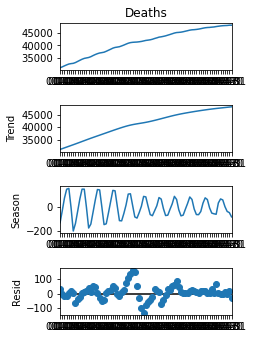

In [106]:
# LOESS smoothing for deaths
zstl = STL(z, period=7)
zres = zstl.fit()
zfig = zres.plot()
zfig.set_size_inches(3,5)

In [93]:
# Check ARIMA seasonality
y_var = yres.observed - yres.trend
z_var = zres.observed - zres.trend

<AxesSubplot:xlabel='Date'>

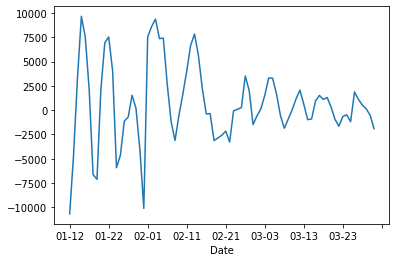

In [94]:
y_var.plot()

<AxesSubplot:xlabel='Date'>

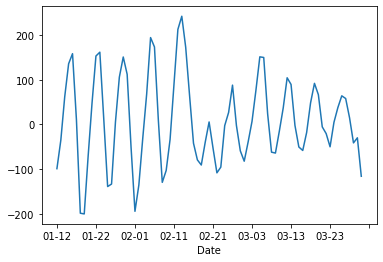

In [95]:
z_var.plot()

# Determine ARIMA parameters for error
- checking differencing levels
- checking autocorrelation and partial-autocorrelation parameters
- again, test out various states to ensure parameters make sense

<ipython-input-96-44f9bf31db38>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


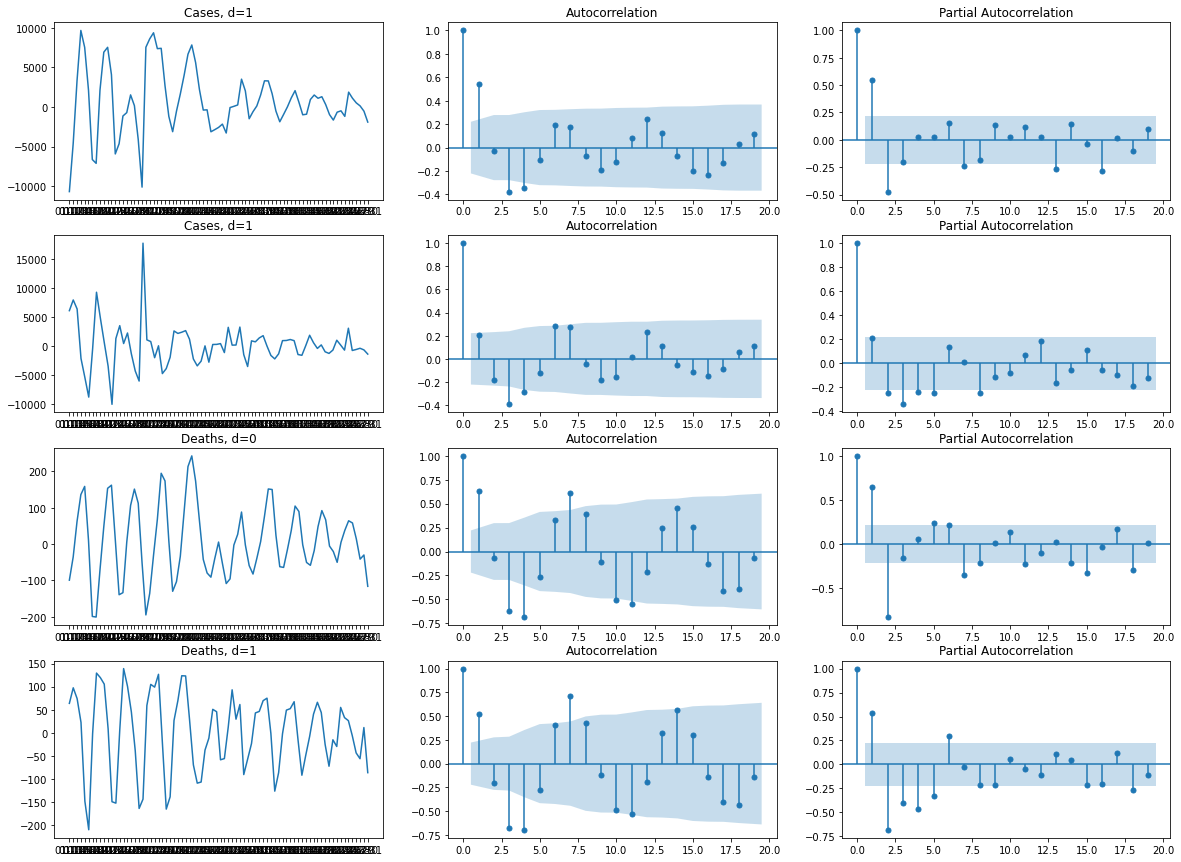

In [96]:
f, ax = plt.subplots(4,3,figsize=(20,15))

ax[0,0].set_title("Cases, d=1")
ax[0,0].plot(y_var)
plot_acf(y_var, ax=ax[0,1])
plot_pacf(y_var, ax=ax[0,2])


y_var_diff = y_var.diff().dropna()
ax[1,0].set_title("Cases, d=1")
ax[1,0].plot(y_var_diff)
plot_acf(y_var_diff, ax=ax[1,1])
plot_pacf(y_var_diff, ax=ax[1,2])

ax[2,0].plot(z_var)
ax[2,0].set_title("Deaths, d=0")
plot_acf(z_var, ax=ax[2,1])
plot_pacf(z_var, ax=ax[2,2])

z_var_diff = z_var.diff().dropna()
ax[3,0].set_title("Deaths, d=1")
ax[3,0].plot(z_var_diff)
plot_acf(z_var_diff, ax=ax[3,1])
plot_pacf(z_var_diff, ax=ax[3,2])

f.show()

Parameter guesses (s = 7 for all)
- California
    - y: d=1, p=1, q=1
    - z: d=1, p=1, q=0 pacf goes too negative
- New York
    - y: d=1, p=1, q=1
    - z: d=1, p=1, q=0 pacf again goes too negative
- Texas
    - looks same
    - let's be conservative and use ypdq = 1,1,1 and zpdq = 1,1,0

# LOESS+SARIMA model, all data

In [97]:
cases_model = STLForecast(y, ARIMA, period=7, model_kwargs={"order": (1,1,1)})
cases_fit = cases_model.fit()
cases_pred = cases_fit.get_prediction(0).predicted_mean[1:]
cases_res = y[1:] - cases_pred

death_model = STLForecast(z, ARIMA, period=7, model_kwargs={"order": (1,1,0)})
death_fit = death_model.fit()
death_pred = death_fit.get_prediction(0).predicted_mean[1:]
death_res = z[1:] - death_pred

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmode

In [98]:
print(cases_fit.summary())
print(death_fit.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                   79
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -743.749
Date:                Sun, 06 Jun 2021   AIC                           1493.497
Time:                        18:24:08   BIC                           1500.567
Sample:                             0   HQIC                          1496.327
                                 - 79                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9731      0.003    374.725      0.000       0.968       0.978
ma.L1         -0.9624      0.003   -304.357      0.000      -0.969      -0.956
sigma2       1.05e+07   5.81e-12   1.81e+18      0.0

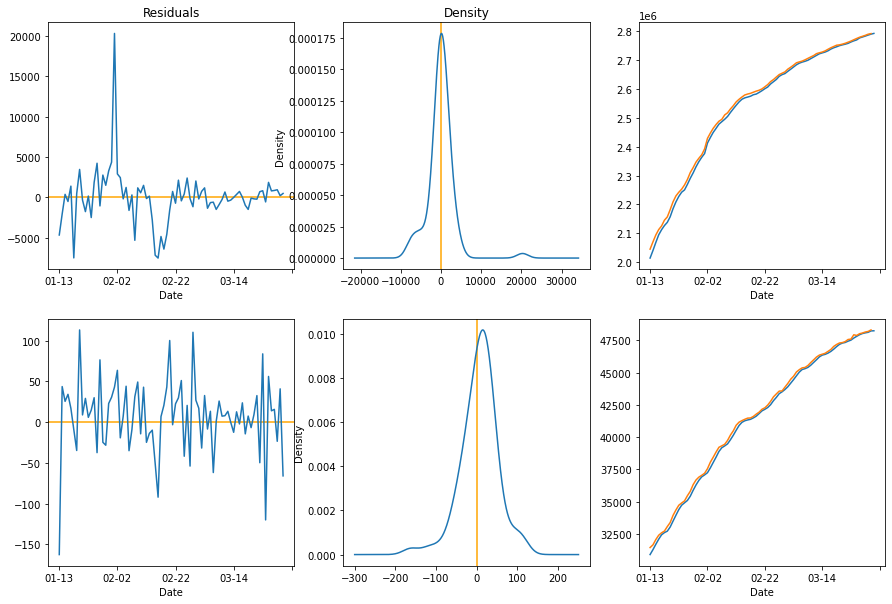

In [99]:
fig, ax = plt.subplots(2,3,figsize=(15,10))
ax[0,0].axhline(0, color='orange')
ax[0,1].axvline(0, color='orange')
ax[1,0].axhline(0, color='orange')
ax[1,1].axvline(0, color='orange')

cases_res.plot(title="Residuals", ax=ax[0,0])
cases_res.plot(kind='kde', title='Density', ax=ax[0,1])
y.plot(ax=ax[0,2])
cases_pred.plot(ax=ax[0,2])

death_res.plot(ax=ax[1,0])
death_res.plot(kind='kde', ax=ax[1,1])
z.plot(ax=ax[1,2])
death_pred.plot(ax=ax[1,2])

plt.show()

# LOESS+SARIMA model, CV data

In [100]:
cases_train = y[:60]
cases_cv = y[60:]
death_train = z[:60]
death_cv = z[60:]

In [101]:
cases_model = STLForecast(cases_train, ARIMA, period=7, model_kwargs={"order": (1,1,1)})
cases_fit = cases_model.fit()
cases_pred = cases_fit.forecast(19)
cases_res = np.array(cases_cv) - cases_pred
cases_pred.index = cases_cv.index

death_model = STLForecast(death_train, ARIMA, period=7, model_kwargs={"order": (1,1,0)})
death_fit = death_model.fit()
death_pred = death_fit.forecast(19)
death_res = np.array(death_cv) - death_pred
death_pred.index = death_cv.index

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/anaconda3/lib/python3.8/sit

In [102]:
print(cases_fit.summary())
print(death_fit.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                   60
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -570.410
Date:                Sun, 06 Jun 2021   AIC                           1146.821
Time:                        18:24:10   BIC                           1153.053
Sample:                             0   HQIC                          1149.254
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9728      0.003    279.483      0.000       0.966       0.980
ma.L1         -0.9623      0.004   -228.167      0.000      -0.971      -0.954
sigma2      1.398e+07    6.5e-12   2.15e+18      0.0

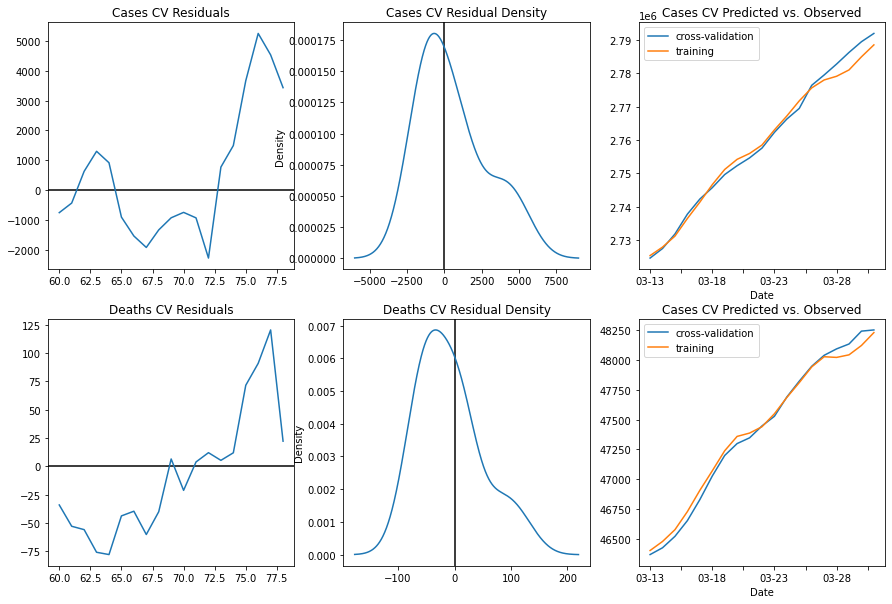

<Figure size 432x288 with 0 Axes>

In [103]:
fig, ax = plt.subplots(2,3,figsize=(15,10))
ax[0,0].axhline(0, color='black')
ax[0,1].axvline(0, color='black')
ax[1,0].axhline(0, color='black')
ax[1,1].axvline(0, color='black')

cases_res.plot(ax=ax[0,0], title="Cases CV Residuals")
cases_res.plot(ax=ax[0,1], kind='kde', title='Cases CV Residual Density')
cases_cv.plot(ax=ax[0,2], label="cross-validation", title='Cases CV Predicted vs. Observed')
cases_pred.plot(ax=ax[0,2], label="training")
ax[0,2].legend()

death_res.plot(ax=ax[1,0], title="Deaths CV Residuals")
death_res.plot(kind='kde', ax=ax[1,1], title='Deaths CV Residual Density')
death_cv.plot(ax=ax[1,2], label="cross-validation", title='Deaths CV Predicted vs. Observed')
death_pred.plot(ax=ax[1,2], label="training")
ax[1,2].legend()

plt.show()

# LOESS+SARIMA model, external test
ignore the massive amount of warnings from the model. i swear im trying.

In [17]:
from arima import arima_test
output, total_score = arima_test(dataset, test_dataset, (1,1,1), (1,1,0))
output = output.set_index('ID')

An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provide

In [18]:
output = output.round()
output = output.astype('int64')
output.to_csv("arima_submission.csv")